In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# 讀入五檔ETF資料

In [2]:
df = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW4/Inputs/ETF 2003_2019.csv', index_col = 'Date')
df = df.set_index(pd.DatetimeIndex(df.index))
title = df.columns.tolist()

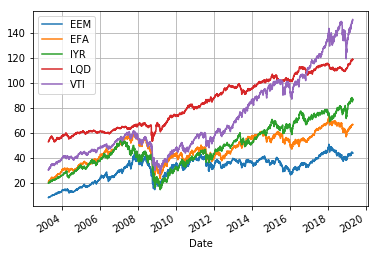

In [3]:
df.plot(grid=True)

# 把CPI資料合併到ETF資料裡

In [4]:
cpi = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW4/Inputs/CPILFESL.csv', index_col = 'DATE')
cpi = cpi.set_index(pd.DatetimeIndex(cpi.index))
cpi = cpi.pct_change(12).dropna()

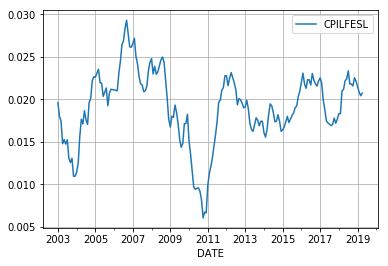

In [5]:
cpi.plot(grid=True)

In [6]:
df['CPI']  = np.nan
for i in range(len(df)):
    tem_d = df.iloc[i]
    df['CPI'].iloc[i] = cpi.loc[(cpi.index.year == tem_d.name.year) & (cpi.index.month == tem_d.name.month)].values

In [7]:
df.head()

,EEM,EFA,IYR,LQD,VTI,CPI
Date,,,,,,
2003-04-14,8.505465,20.834179,20.040634,52.943714,30.601860,0.01476
2003-04-15,8.606520,21.119843,20.126944,53.040596,30.800758,0.01476
2003-04-16,8.705894,20.980284,20.180252,53.398998,30.391888,0.01476
2003-04-17,8.768209,21.283392,20.368092,53.287613,30.863367,0.01476
2003-04-21,8.764842,21.209249,20.431545,53.398998,30.856012,0.01476


In [8]:
df.tail()

,EEM,EFA,IYR,LQD,VTI,CPI
Date,,,,,,
2019-04-24,43.770000,66.230003,86.370003,118.562660,149.600006,0.020728
2019-04-25,43.709999,66.180000,86.199997,118.503021,149.350006,0.020728
2019-04-26,43.880001,66.449997,86.849998,118.920494,150.160004,0.020728
2019-04-29,43.970001,66.720001,86.019997,118.453331,150.380005,0.020728
2019-04-30,43.930000,66.760002,87.000000,118.503021,150.389999,0.020728


# 隨機權重，將權重代入起始資料換算mean跟std並打點，找出十組權重

In [9]:
begin_invest = 10000

In [10]:
#隨機抽樣
def gen_wei(num):
    mylist = []
    for i in range(num):
        mylist.append(random.random())
    
    s = sum(mylist)
    for j in range(num):
        mylist[j] = mylist[j] / s
    
    #10次方
    mylist = [i**10 / sum(i**10 for i in mylist) for i in mylist]
    
    return mylist

In [11]:
#設計成丟入要畫效率前緣的區間，此函式只負責產生mean, std跟weights
def gen_result(dataframe, times = 10000):
    
    #把pd dataframe變成np array
    dataframe = np.array(dataframe)
    
    #先把第一筆數據生出來，存入result裡，之後產生新數據也都存在result裡
    weight = gen_wei(5)
    weight = [begin_invest * i for i in weight]
    weight = weight / dataframe[0]
    tem = sum((dataframe * weight).T)
    change = (tem[1:]/tem[:-1]) - 1
    std_mean = np.array([change.std() * math.sqrt(252), change.mean() * 252]) #這是把日報酬、標準差換成年
    result = np.append(std_mean, weight)
    result = np.array([result]) #要這樣處理，後面才能疊加
    
    #隨機次數-1，第一次已經在前面做好了
    for t in range(times - 1):
        
        #每次隨機均利用先前函數，重新生成一組權重
        weight = gen_wei(5)
        weight = [begin_invest * i for i in weight]
        weight = weight / dataframe[0]
        
        #先將各資產價格成以對應權重並加總成淨值，將之算成日變動率，近一步算std及mean，把std & mean & weight合在一起，存入result
        tem = sum((dataframe * weight).T)
        change = (tem[1:]/tem[:-1]) - 1 #後一日除以前一日減一
        std_mean = np.array([change.std() * math.sqrt(252), change.mean() * 252])
        tem_2 = np.append(std_mean, weight)
        tem_2 = np.array([tem_2]) #要這樣處理，才能跟前面疊加
        result = np.concatenate((result, tem_2), axis=0) #疊加方式
    
    #加入進位到小數點以下第三位的std
    std_round = np.round(result.T[0], 3)
    std_round = np.array([std_round])
    result = np.append(result, std_round.T, axis=1)
    #result = np.concatenate((result.T, std_round), axis=0).T #兩種寫法
     
    return result

In [12]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def scatter_graph(months = 6, times = 10000):
    plt.figure(figsize=(12,9))

    result =  gen_result(df[title][:21 * months], times) #先測試以6個月來畫效率前緣
    
    ten_quantile = []
    #把進位到小數點第三位的std分成10個quantile
    #ten_std_quantile = np.percentile(result.T[-1], [0, 11, 22, 33, 44, 55, 66, 77, 88, 100], axis=0, interpolation = 'nearest')
    
    #這種方法可以比分散比較平均
    ten_std_quantile = []
    for i in range(10):
        find = result.T[-1].min() + ((result.T[-1].max() - result.T[-1].min())/9) * i
        ten_std_quantile.append(find_nearest(result.T[-1], find))
    ten_std_quantile = np.array(ten_std_quantile)
    
    for i in range(10):
        #每個quantile下有多個點
        tem = result[np.where((result.T[-1] == ten_std_quantile[i]))]
        #該quantile下所有點中mean最大的那一行，加入資料中
        ten_quantile.append(tem[np.argmax(tem.T[1], axis=0)])
    ten_quantile = np.array(ten_quantile)

    #畫圖，最後一起print出
    plt.scatter(result.T[0], result.T[1], s = 1)
    plt.scatter(ten_quantile.T[0], ten_quantile.T[1], color = 'red')

    #產生圖之資訊
    #plt.legend(name, loc = 'best', prop = {'size' : 16})
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Standard Deviation', size = 16)
    plt.ylabel('Expected Return', size = 16)
    plt.title(str(times) + ' times of MonteCarlo for EEM/EFA/IYR/LQD/VTI (' + str(months) +' months data)', size = 18)
    
    return result, ten_quantile

In [13]:
#result, ten_quantile = scatter_graph(6, 50000)

# 根據找出的權重，一組組逐日開始並滾十年，記下價值分配並統整出結果

In [14]:
def Income_Portfolio_Result(d_yield, months = 6, times = 50000):
    
    result, ten_quantile = scatter_graph(months, times)
    
    #可以根據先前用多少個月來畫效率前緣，此處使用多少資料來產生結果
    price = np.array(df[21 * months:])

    #根據先前使用多少個月來畫效率前緣，此處訂定開始日，結束日都是2009/03/09，區間內有多少日最後就有幾筆資料，並在此區間內逐日開始觀察結果
    s_day = df.iloc[21 * months].name
    e_day = df.loc['2009-03-09'].name
    days = len(df.loc[s_day:e_day]) #在此期間內的任一天開始

    #用於儲存所有權重計算結果的dataframe，最後再output出
    output = pd.DataFrame(columns = ['Portfolio ' + str(i) for i in range(1, 11)], 
                          index = [i + ' units' for i in title] + ['Max', 'Mean', 'Min', '75 Quantile', '50 Quantile', '25 Quantile'])
    
    #10組權重分別下去算
    for each in range(10):
        weight = ten_quantile[each][2:7] #第一到十組權重
        all_nav = sum((price.T[:-1].T * weight).T) #由於price裡面含五檔etf及cpi資訊，先將它轉置，排除最後一行cpi，再轉置回來，則price還是可以保存cpi

        #區間內一日日開始，並往後推衍十年，不記錄逐日價格，只記下第十年那天的淨值是多少
        data = []
        for i in range(days):
            tem_price = all_nav[i] #第一日
            for j in range(1, 21 * 12 * 10 + 1): #10年一天天跑，含第一筆起始資料總共有2521筆
                tem_price *= (all_nav[i + j] / all_nav[i + j - 1])
                #若符合條件，就要除息，並採用price裡的cpi資料
                if (j >= 20) & (j % 21 == 0): #如果在新的月的第一天，第一個月不用
                    tem_price -= begin_invest * (d_yield/12) * ((1 + price.T[-1][i + j]) ** ((j-21)/252))
            data.append(tem_price / all_nav[i]) #改成return報酬
        data = np.array(data)

        #五檔etf的權重分別寫入
        for j in range(5):
            output['Portfolio ' + str(each+1)].iloc[j] = ten_quantile[each][2+j]

        output['Portfolio ' + str(each+1)].loc['Max'] = np.max(data)
        output['Portfolio ' + str(each+1)].loc['Mean'] = np.mean(data)
        output['Portfolio ' + str(each+1)].loc['Min'] = np.min(data)
        output['Portfolio ' + str(each+1)].loc['75 Quantile'] = np.percentile(data, 75, interpolation = 'nearest')
        output['Portfolio ' + str(each+1)].loc['50 Quantile'] = np.percentile(data, 50, interpolation = 'nearest')
        output['Portfolio ' + str(each+1)].loc['25 Quantile'] = np.percentile(data, 25, interpolation = 'nearest')
    
    return output

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,119.625,279.293,402.47,517.002,545.363,655.89,723.812,904.997,1040.89,1175.71
EFA units,1.95554e-07,7.71929e-06,1.85337e-10,0.041041,14.4589,6.41138e-05,40.0783,0.842944,7.42043,1.45937e-09
IYR units,128.279,152.685,139.223,124.538,172.81,182.672,150.124,114.019,49.5053,1.10737e-10
LQD units,121.104,86.2158,71.5227,58.6659,30.0836,14.3408,0.00129275,1.71876e-08,3.55196e-10,2.57355e-13
VTI units,0.00212795,2.91304e-08,8.79286e-06,8.82096e-09,0.138673,0.0405833,8.02679e-11,4.08918e-07,2.94064e-10,1.18398e-14
Max,2.01041,2.25328,2.27611,2.28927,2.52679,2.61354,2.57669,2.5115,2.57042,2.66875
Mean,1.26284,1.3359,1.36632,1.39079,1.42053,1.45339,1.44845,1.47709,1.47776,1.4863
Min,1.04045,1.03152,1.00844,0.979502,0.981887,0.970698,0.941975,0.922992,0.894672,0.875508
75 Quantile,1.32136,1.50071,1.59371,1.66405,1.71527,1.78691,1.81223,1.87684,1.90441,1.92584
50 Quantile,1.23113,1.25532,1.25131,1.2503,1.25919,1.26633,1.24882,1.25122,1.23249,1.22353


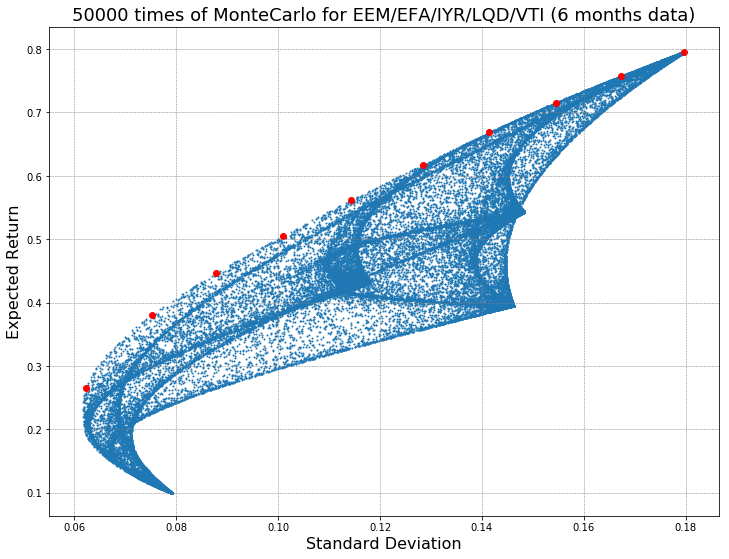

In [15]:
five_percent_six_months_IP = Income_Portfolio_Result(0.05, 6)
five_percent_six_months_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,42.112,290.502,434.268,417.618,543.79,657.272,747.22,758.955,958.958,1175.71
EFA units,0.273316,4.77792e-06,2.96783,98.076,83.812,80.4666,88.2711,132.927,88.4668,1.0307e-12
IYR units,26.4117,53.9685,33.2255,0.404763,0.227387,4.56852e-06,0.00334058,38.6857,0.0239952,2.16288e-11
LQD units,133.165,115.401,105.075,83.0414,68.2206,51.6235,34.1008,4.20655e-07,8.04258e-12,4.3019e-21
VTI units,67.2047,11.0399,0.509415,1.47324e-08,0.400221,2.08694e-06,1.06266e-08,0.000986159,0.000133406,3.07231e-08
Max,1.93916,1.91315,1.89451,1.87904,1.98472,2.1228,2.23112,2.30621,2.46219,2.66875
Mean,1.29557,1.28212,1.28957,1.24943,1.28364,1.3089,1.32615,1.3393,1.3649,1.4134
Min,1.11653,1.0285,0.968864,0.923404,0.911032,0.898747,0.888516,0.888251,0.873193,0.875508
75 Quantile,1.3012,1.43843,1.50642,1.46595,1.53646,1.58889,1.62684,1.66509,1.70475,1.79172
50 Quantile,1.25539,1.21273,1.19997,1.14076,1.15239,1.15674,1.15318,1.14677,1.15621,1.1848


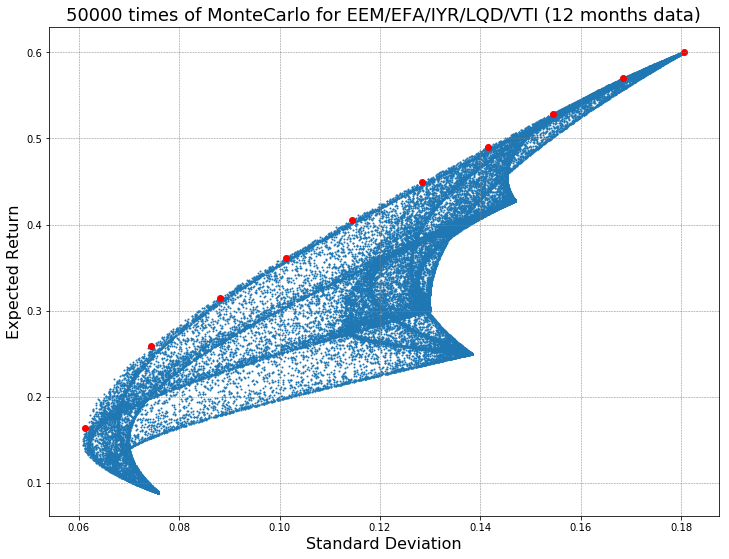

In [16]:
five_percent_one_year_IP = Income_Portfolio_Result(0.05, 12)
five_percent_one_year_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,5.61405e-06,152.228,242.96,89.4659,194.926,320.673,592.086,852.855,1015.59,1175.71
EFA units,6.3864e-08,17.1005,67.2188,193.691,198.353,211.186,119.66,4.36906e-05,3.05415,3.09965e-11
IYR units,2.91488,94.5912,60.1106,136.923,151.12,142.875,123.3,136.977,64.5092,9.3266e-15
LQD units,137.898,121.89,91.551,46.3974,22.2112,6.83362e-06,2.13544e-05,0.0176999,8.26905e-15,1.21078e-09
VTI units,86.293,1.26478e-09,15.7295,0.104221,0.165428,0.305007,5.22829e-10,0.000761252,0.18058,4.20357e-13
Max,1.91944,1.91685,2.03122,2.36909,2.51931,2.56972,2.50125,2.55612,2.42235,2.32195
Mean,1.32968,1.21104,1.21119,1.17661,1.19643,1.20145,1.22878,1.26983,1.24522,1.22655
Min,1.12767,1.04017,1.01274,0.927563,0.931205,0.932476,0.929717,0.934047,0.90114,0.875508
75 Quantile,1.37362,1.23125,1.23532,1.21831,1.2305,1.23385,1.26391,1.30493,1.2895,1.28296
50 Quantile,1.28454,1.16397,1.15197,1.09855,1.10503,1.09761,1.123,1.15262,1.12403,1.10522


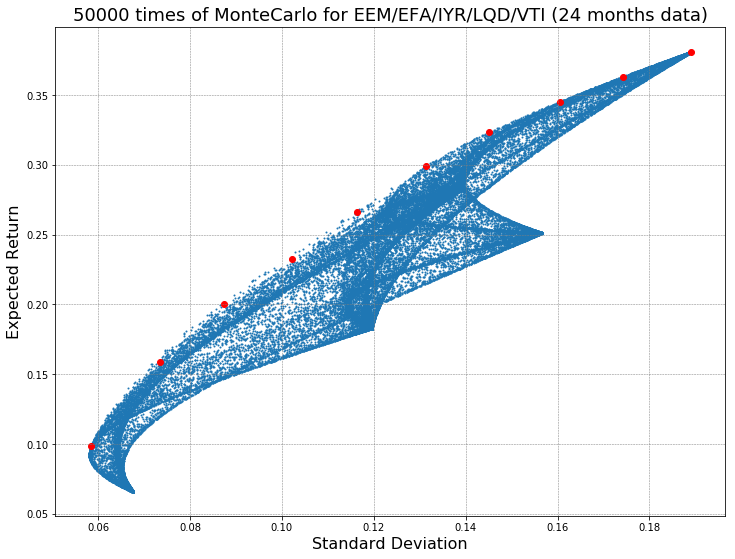

In [17]:
five_percent_two_years_IP = Income_Portfolio_Result(0.05, 24)
five_percent_two_years_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,0.00277986,2.72628e-15,69.313,169.514,298.845,365.569,590.07,812.665,1005.25,1175.71
EFA units,0.174915,106.656,146.946,112.449,112.199,161.656,89.4045,9.46343,1.04138e-11,3.52833e-08
IYR units,0.162029,62.552,79.2789,151.923,148.574,162.12,150.755,143.792,72.3461,7.28252e-12
LQD units,145.625,108.031,84.0869,59.8874,40.4787,5.16281,1.51989,0.00316658,3.34636e-05,6.72073e-12
VTI units,74.6082,26.2974,10.0745,0.00405842,2.94971e-06,0.0118709,0.549471,0.290737,2.07628e-05,4.62208e-12
Max,1.82201,1.95901,2.05989,2.35861,2.42585,2.60137,2.57239,2.56375,2.43741,2.32195
Mean,1.34723,1.20811,1.17284,1.21713,1.21848,1.2146,1.23,1.24471,1.21338,1.18365
Min,1.19463,1.01713,0.970725,0.968824,0.973347,0.951536,0.945974,0.938074,0.904289,0.875508
75 Quantile,1.38326,1.22878,1.17977,1.2105,1.20303,1.19083,1.20637,1.23021,1.2156,1.19999
50 Quantile,1.30088,1.14373,1.09836,1.12263,1.11166,1.09369,1.10623,1.11847,1.09728,1.07334


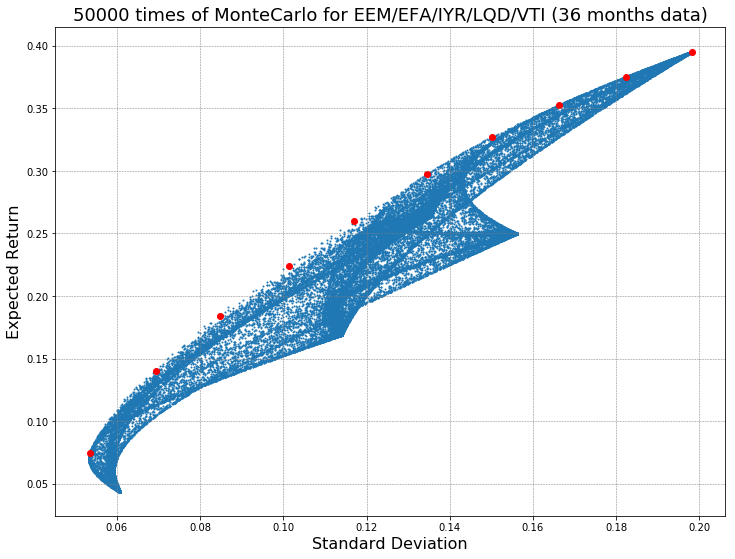

In [18]:
five_percent_three_years_IP = Income_Portfolio_Result(0.05, 36)
five_percent_three_years_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,125.349,220.624,411.337,510.455,448.963,680.889,737.32,907.8,1047.3,1175.71
EFA units,1.65577e-07,53.4427,0.172801,27.1244,86.4878,0.00388594,21.1393,1.08115,1.72189e-12,2.37257e-10
IYR units,104.944,123.655,133.87,86.2098,160.549,158.357,164.017,109.697,54.5008,1.31904e-16
LQD units,125.3,85.5877,72.0566,62.0912,21.947,19.4814,0.0248991,1.07335,1.02706e-06,2.6103e-09
VTI units,6.43347,0.0196981,2.08079e-16,2.55515,6.68842e-05,0.118843,8.27378e-05,0.0322102,1.76521e-06,1.50877e-15
Max,1.70267,1.92711,2.04853,1.99644,2.3073,2.34291,2.42823,2.32914,2.36663,2.45942
Mean,1.06205,1.12159,1.21291,1.22737,1.24132,1.32016,1.338,1.36147,1.37373,1.38295
Min,0.899337,0.882221,0.901612,0.871116,0.879912,0.883117,0.875687,0.856074,0.836671,0.819679
75 Quantile,1.09035,1.23051,1.40148,1.45918,1.46877,1.61708,1.66202,1.71803,1.76333,1.78844
50 Quantile,1.03201,1.06593,1.1179,1.1077,1.1131,1.15446,1.15728,1.15878,1.15196,1.14506


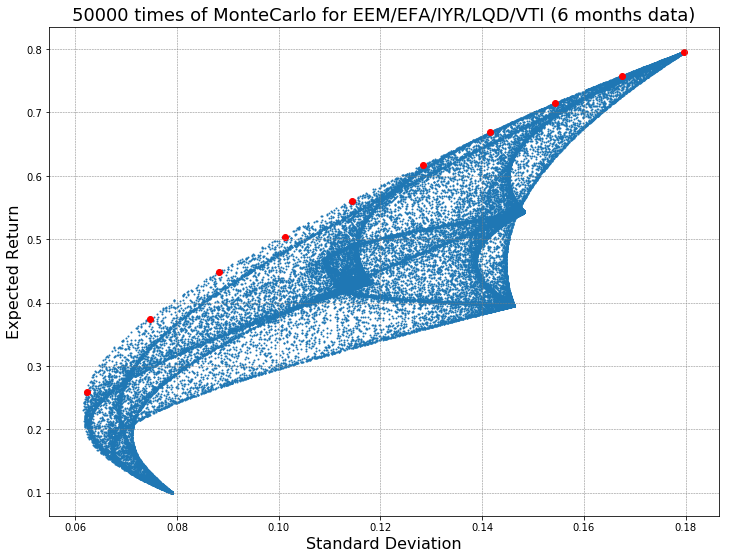

In [19]:
seven_percent_six_months_IP = Income_Portfolio_Result(0.07, 6)
seven_percent_six_months_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,55.128,294.974,436.697,385.984,529.208,621.5,733.269,758.81,957.714,1175.71
EFA units,1.01172e-05,0.985234,0.00038346,112.542,93.998,89.8257,96.4182,131.128,88.923,8.66162e-10
IYR units,30.2541,59.7885,36.1301,16.1646,9.7061e-05,39.7679,0.0485023,40.4596,0.00115461,8.83184e-13
LQD units,135.91,118.473,104.286,75.8326,66.8335,38.407,33.119,0.0014536,0.0290302,7.84831e-13
VTI units,56.5068,4.49714e-17,1.3185,1.09436,0.0671443,0.392993,4.35552e-05,0.101267,7.50546e-12,4.44375e-12
Max,1.62557,1.6649,1.7146,1.75004,1.78758,1.99387,1.99872,2.14547,2.25133,2.45942
Mean,1.05774,1.10259,1.14579,1.10923,1.14919,1.19924,1.20901,1.23227,1.2639,1.318
Min,0.904942,0.890644,0.867668,0.831032,0.822707,0.833063,0.815832,0.820914,0.811996,0.819679
75 Quantile,1.06617,1.22726,1.32922,1.29468,1.36701,1.45434,1.48375,1.52833,1.57841,1.66849
50 Quantile,1.02032,1.04602,1.06691,1.01555,1.03525,1.05908,1.05624,1.05797,1.0745,1.10718


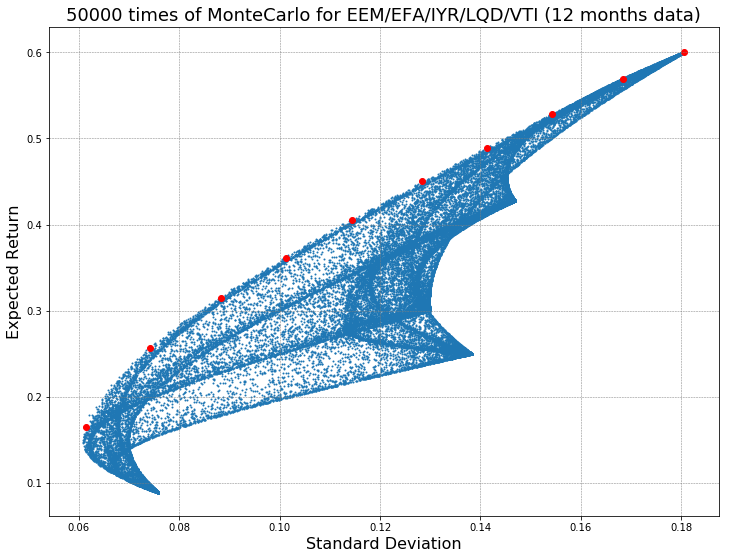

In [20]:
seven_percent_one_year_IP = Income_Portfolio_Result(0.07, 12)
seven_percent_one_year_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,4.54954,205.709,136.513,244.479,118.531,401.527,569.358,832.647,1018.4,1175.71
EFA units,0.00704609,3.10239e-10,108.828,92.3255,220.494,144.144,160.679,39.4259,6.33138e-09,7.74889e-09
IYR units,6.03354,69.5257,108.443,143.65,149.349,162.664,86.8416,104.615,66.7674,7.42993e-14
LQD units,139.15,129.515,83.0731,56.836,14.7712,6.0784,1.31023,6.72387e-07,6.67244e-08,7.71949e-15
VTI units,80.8169,1.37042e-08,0.00248535,3.56605,20.356,4.59268e-10,1.79867e-15,7.32271e-07,0.00036653,6.8754e-16
Max,1.61281,1.60907,1.86942,2.12041,2.38249,2.37233,2.21117,2.29892,2.26975,2.17911
Mean,1.08127,1.04094,1.03038,1.08741,1.07171,1.11455,1.09958,1.15468,1.16103,1.14748
Min,0.897487,0.897876,0.84734,0.872206,0.825724,0.867601,0.834462,0.851359,0.840742,0.819679
75 Quantile,1.12991,1.05684,1.05328,1.10868,1.11125,1.13556,1.13529,1.19033,1.19912,1.19829
50 Quantile,1.04016,1.00052,0.977498,1.02128,0.984078,1.02328,1.00581,1.05011,1.04913,1.03482


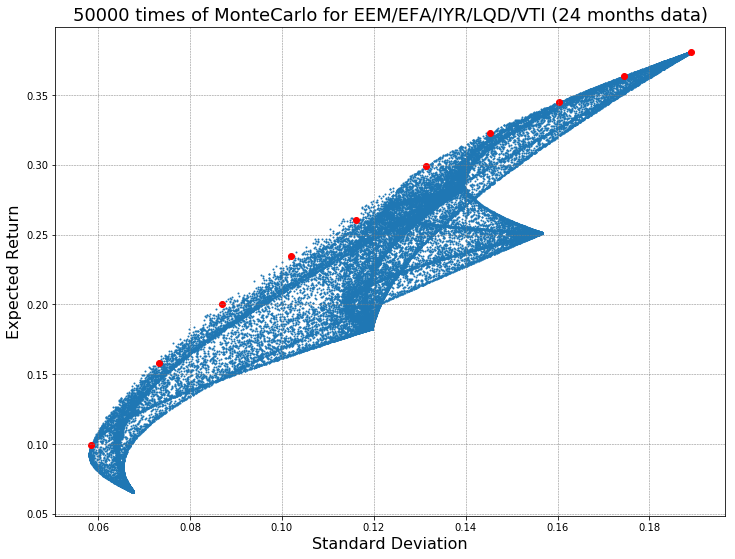

In [21]:
seven_percent_two_years_IP = Income_Portfolio_Result(0.07, 24)
seven_percent_two_years_IP

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,Portfolio 6,Portfolio 7,Portfolio 8,Portfolio 9,Portfolio 10
EEM units,1.00673e-09,0.00480022,170.926,243.642,187.13,339.384,591.927,814.681,1005.27,1175.71
EFA units,1.25595e-05,127.733,36.9201,115.841,206.437,148.338,68.6083,3.43301e-08,1.2581e-10,8.27287e-09
IYR units,4.73825e-05,55.9306,122.414,80.119,137.458,196.848,175.686,153.227,72.3302,1.11472e-11
LQD units,145.938,117.443,100.543,73.553,25.4011,1.47033,6.61544e-05,4.27293e-17,0.000646277,2.32074e-11
VTI units,74.2928,4.05524e-15,0.0207603,0.472446,0.256679,0.00265285,0.494495,9.38724e-14,0.00568752,1.30832e-07
Max,1.53747,1.51599,1.84613,1.86873,2.21059,2.49333,2.44564,2.40945,2.27784,2.17911
Mean,1.10749,0.954257,1.06799,1.03879,1.05075,1.11905,1.14524,1.1591,1.13129,1.1087
Min,0.966184,0.808982,0.881149,0.861646,0.822796,0.858828,0.878447,0.872396,0.842625,0.819679
75 Quantile,1.14603,0.963338,1.06725,1.03293,1.04414,1.09486,1.11843,1.14358,1.13052,1.12181
50 Quantile,1.06258,0.908816,1.00311,0.963354,0.954721,1.00179,1.02688,1.03923,1.02207,1.0041


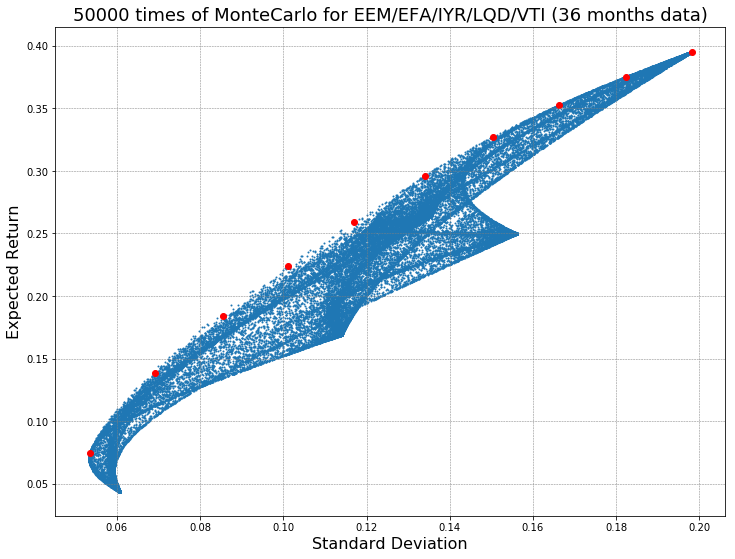

In [22]:
seven_percent_three_years_IP = Income_Portfolio_Result(0.07, 36)
seven_percent_three_years_IP

In [24]:
#five_percent_six_months_IP.to_csv('/Users/Kang/Desktop/five_percent_six_months_IP.csv')
#five_percent_one_year_IP.to_csv('/Users/Kang/Desktop/five_percent_one_year_IP.csv')
#five_percent_two_years_IP.to_csv('/Users/Kang/Desktop/five_percent_two_years_IP.csv')
#five_percent_three_years_IP.to_csv('/Users/Kang/Desktop/five_percent_three_years_IP.csv')
#seven_percent_six_months_IP.to_csv('/Users/Kang/Desktop/seven_percent_six_months_IP.csv')
#seven_percent_one_year_IP.to_csv('/Users/Kang/Desktop/seven_percent_one_year_IP.csv')
#seven_percent_two_years_IP.to_csv('/Users/Kang/Desktop/seven_percent_two_years_IP.csv')
#seven_percent_three_years_IP.to_csv('/Users/Kang/Desktop/seven_percent_three_years_IP.csv')